In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor,Resize, Grayscale, Normalize
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
from torch.utils.data import Dataset
import glob
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
"""
from google.colab import drive
drive.mount('/content/gdrive')

import zipfile
import os
zip_file = "/content/gdrive/MyDrive/base_v2.1.zip"
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

root_dir = "base_v2.1"
train_data = VisionDataset(root = os.path.join(root_dir,'train_x1'),
                         transform= transforms)
"""
print("Done")

Done


In [100]:
class My_class(Dataset):
    def __init__(self, classes_paths, transforms=None, target_transform=None):
        #print(glob.glob(data_dir))
        self.classes = []
        self.images = []
        self.transform = transforms
        for actual_class in classes_paths:
            if actual_class == 1:
                print("")
            paths = classes_paths[actual_class]
            for path in paths:
                # print("Loading " + path)
                for top, dirs, files in os.walk(path):
                    for i, name in enumerate(files):
                        if not os.path.isfile(top + "//" + name):
                            continue
                        try:
                            imag = cv2.imread(top + "//" + name)
                        except Exception:
                            continue
                        self.images.append(imag)
                        self.classes.append(actual_class)
        self.images, self.classes = np.array(self.images), torch.tensor(np.array(self.classes), dtype=torch.int64)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.transform==None:
            return self.images[idx], self.classes[idx]
        else:
            return self.transform(np.array(self.images[idx]).astype(np.float32)), self.classes[idx]

In [101]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
    
    def forward(self, x):
        return self.block(x)


class CNN(nn.Module):
    def __init__(self, n_classes=31):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(1, 16),
            nn.MaxPool2d(2),
            ConvBlock(16, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            nn.Flatten()
        )
        
        cnn_out = self.model(torch.ones(1, 1, 32, 32))
        print(cnn_out.size())
        
        self.fc = nn.Sequential(
            nn.Linear(cnn_out.size()[1], 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [102]:
def validate(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def test(model, loss_function, epochs , tag = "detection"):
    correct = 0
    total = 0
    loss_test = []
    for epoch in range(epochs):
        ep_loss = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
          # calculate outputs by running images through the network
                outputs = model(images)
                loss = loss_function(outputs, labels)
                ep_loss += loss.item()
          # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        loss_test.append(ep_loss /len(test_loader))
        print(f"Epoch={epoch} loss={loss_test[epoch]:.4}")
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    return loss_test

In [103]:
def train(model, loss_function, optimizer, epochs):
    loss_hist = []
    test_accuracy = []
    train_accuracy = []
    for epoch in range(epochs):
        ep_loss = 0
        for images, labels in  tqdm(train_loader): # get bacth
            optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
            outputs = model.forward(images) # call forward inside
            loss = loss_function(outputs, labels) # calculate loss
            loss.backward() # calculate gradients
            optimizer.step() # performs a single optimization step (parameter update).
            ep_loss += loss.item()
        loss_hist.append(ep_loss /len(train_loader))
        print(f"Epoch={epoch} loss={loss_hist[epoch]:.4}")
        test_accuracy.append(validate(model, test_loader))
        train_accuracy.append(validate(model, train_loader))
    return test_accuracy,train_accuracy, loss_hist

In [104]:
CLASSES_PATHS = {
    0: ["base_v2.1//train_x1//SMD0402_CL//correct"],
    1: ["base_v2.1//train_x1//SMD0402_R//correct"],
    2: ["base_v2.1//train_x1//SMD0603_CL//correct"],
    3: ["base_v2.1//train_x1//SMD0603_D//correct"],
    4: ["base_v2.1//train_x1//SMD0603_R//correct"],
    5: ["base_v2.1//train_x1//SMD0805_CL//correct"],
    6: ["base_v2.1//train_x1//SMD0805_R//correct"],
    7: ["base_v2.1//train_x1//SMD1206_C//correct"],
    8: ["base_v2.1//train_x1//SMD1206_R//correct"],
    9: ["base_v2.1//train_x1//SMD1210_C//correct"],
    10: ["base_v2.1//train_x1//2-SMD//correct"],
    11: ["base_v2.1//train_x1//SMA//correct"],
    12: ["base_v2.1//train_x1//SMB//correct"],
    13: ["base_v2.1//train_x1//SOD110//correct"],
    14: ["base_v2.1//train_x1//SOD323F//correct"],
    15: ["base_v2.1//train_x1//SOD523//correct"],
    16: ["base_v2.1//train_x1//SOT23-5//correct"],
    17: ["base_v2.1//train_x1//SOT23-6//correct"],
    18: ["base_v2.1//train_x1//SOT143//correct"],
    19: ["base_v2.1//train_x1//SOT323//correct"],
    20: ["base_v2.1//train_x1//SOT323-5//correct"],
    21: ["base_v2.1//train_x1//SOT343//correct"],
    22: ["base_v2.1//train_x1//SOT363//correct"],
    23: ["base_v2.1//train_x1//SOT523//correct"],
    24: ["base_v2.1//train_x1//SOT723//correct"],
    25: ["base_v2.1//train_x1//DIP-%d//correct"],
    26: ["base_v2.1//train_x1//LQFP0.4-%d//correct"],
    27: ["base_v2.1//train_x1//LQFP0.5-%d&TFSOP-%d//correct"],
    28: ["base_v2.1//train_x1//LQFP0.8-%d//correct"],
    29: ["base_v2.1//train_x1//LQFP0.65-%d&SSOP-%d//correct"],
    30: ["base_v2.1//train_x1//SOIC-%d//correct"]
}
transforms = torchvision.transforms.Compose([ToTensor(),
                                             Grayscale(1),
                                             Resize([32, 32]),
                                             Normalize(mean=0, std=1)])

dataset = My_class(CLASSES_PATHS, transforms)

c:\python368\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [105]:
len(dataset)

8164

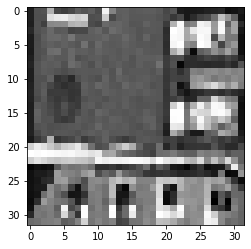

In [106]:
img, lbl = dataset[8160]
plt.imshow(img[0], cmap='gray')
plt.show()

In [107]:
param = 0.9
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [int(len(dataset) * param),
                                                                      len(dataset) - int(len(dataset) * param)])
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [108]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 32, 32])
Labels batch shape: torch.Size([32])


In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [110]:
model = CNN()  # Create model instance
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().cuda()
test_accuracy, train_accuracy, loss_hist = train(model, criterion, optimizer, epochs=30)

torch.Size([1, 512])


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 38.18it/s]


Epoch=0 loss=0.8837


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 38.46it/s]


Epoch=1 loss=0.3689


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:05<00:00, 38.59it/s]


Epoch=2 loss=0.247


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.53it/s]


Epoch=3 loss=0.204


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.09it/s]


Epoch=4 loss=0.1378


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.57it/s]


Epoch=5 loss=0.1063


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 36.52it/s]


Epoch=6 loss=0.08055


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 35.45it/s]


Epoch=7 loss=0.07976


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.30it/s]


Epoch=8 loss=0.07602


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.39it/s]


Epoch=9 loss=0.06239


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:07<00:00, 32.50it/s]


Epoch=10 loss=0.03879


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:07<00:00, 31.76it/s]


Epoch=11 loss=0.03502


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.14it/s]


Epoch=12 loss=0.05295


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.30it/s]


Epoch=13 loss=0.05769


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.62it/s]


Epoch=14 loss=0.0384


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.54it/s]


Epoch=15 loss=0.03632


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.43it/s]


Epoch=16 loss=0.03355


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.06it/s]


Epoch=17 loss=0.03315


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.53it/s]


Epoch=18 loss=0.02958


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.60it/s]


Epoch=19 loss=0.02241


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.61it/s]


Epoch=20 loss=0.02132


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.23it/s]


Epoch=21 loss=0.02455


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 33.64it/s]


Epoch=22 loss=0.03058


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 33.50it/s]


Epoch=23 loss=0.03707


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:07<00:00, 31.22it/s]


Epoch=24 loss=0.03985


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.45it/s]


Epoch=25 loss=0.03004


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.58it/s]


Epoch=26 loss=0.02324


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.08it/s]


Epoch=27 loss=0.01874


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 34.54it/s]


Epoch=28 loss=0.01779


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 33.58it/s]


Epoch=29 loss=0.01015


In [112]:
validate(model, test_loader)

0.9412484700122399

In [116]:
acc_by_class = {}
if 1 not in acc_by_class:
    acc_by_class[1] = 'fdf'

In [144]:
def validate_by_class(model, dataset_test):
    acc_by_class = {}
    
    with torch.no_grad():
        model.eval()
        for image, label in dataset_test:
            outputs = model(image.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted.squeeze() == label).sum().item()
            
            if int(label) not in acc_by_class:
                acc_by_class[int(label)] = (correct, 1)
            if int(label) in acc_by_class:
                correct_prev, total_prev = acc_by_class[int(label)]
                acc_by_class[int(label)] = (correct_prev + correct, total_prev + 1)
    return acc_by_class

In [147]:
d = validate_by_class(model, dataset_test)
for key in CLASSES_PATHS.keys():
    try:
        print(CLASSES_PATHS[key], d[key])
    except:
        print(CLASSES_PATHS[key], 'NOT FOUND')

['base_v2.1//train_x1//SMD0402_CL//correct'] (212, 214)
['base_v2.1//train_x1//SMD0402_R//correct'] (109, 112)
['base_v2.1//train_x1//SMD0603_CL//correct'] (79, 83)
['base_v2.1//train_x1//SMD0603_D//correct'] (4, 5)
['base_v2.1//train_x1//SMD0603_R//correct'] (61, 62)
['base_v2.1//train_x1//SMD0805_CL//correct'] (51, 54)
['base_v2.1//train_x1//SMD0805_R//correct'] (90, 94)
['base_v2.1//train_x1//SMD1206_C//correct'] (16, 18)
['base_v2.1//train_x1//SMD1206_R//correct'] (15, 18)
['base_v2.1//train_x1//SMD1210_C//correct'] (15, 15)
['base_v2.1//train_x1//2-SMD//correct'] (9, 9)
['base_v2.1//train_x1//SMA//correct'] (5, 6)
['base_v2.1//train_x1//SMB//correct'] (3, 4)
['base_v2.1//train_x1//SOD110//correct'] (2, 2)
['base_v2.1//train_x1//SOD323F//correct'] (1, 3)
['base_v2.1//train_x1//SOD523//correct'] (2, 5)
['base_v2.1//train_x1//SOT23-5//correct'] (3, 5)
['base_v2.1//train_x1//SOT23-6//correct'] (5, 7)
['base_v2.1//train_x1//SOT143//correct'] NOT FOUND
['base_v2.1//train_x1//SOT323//cor

In [113]:
torch.save(model.state_dict(), '05_06_22.pth')
torch.save(model, '05_06_22.pth')

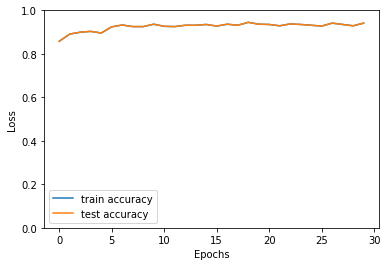

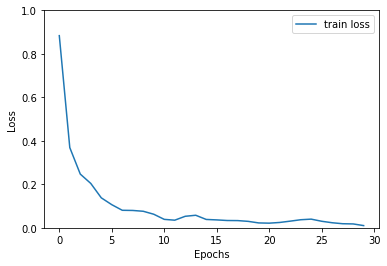

In [111]:
# torch.save(model.state_dict(), '/content/gdrive/MyDrive/05_04_22.h5')
# torch.save(model, '/content/gdrive/MyDrive/05_04_22_full.h5')

epochs = 30

plt.plot(range(epochs), train_accuracy, label='train accuracy')
plt.plot(range(epochs), test_accuracy, label='test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

epochs = 30
plt.plot(range(epochs), loss_hist, label='train loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.show()